# Presentation Video 
Available on Youtube: https://www.youtube.com/watch?v=Dhxnm5NgdBw


# Description of project:

Meal calorie calculation can be time consuming for people on a diet. In this project, We propose an image-based calorie calculator that is capable of estimating the total calories of a meal for the user. The input is a photo of raw ingredients for a meal (e.g. a photo containing two eggs, a red pepper, a slice of chicken breast, etc.) The model will output a list of food objects and  corresponding calories, as well as the estimated total calories. 

The 2 major goals of this project are:
1. object recognition and localization (for identifying food)
2. semantic segmentation (for estimating the serve)

Flow chart below demonstrates the overall structure of our design.

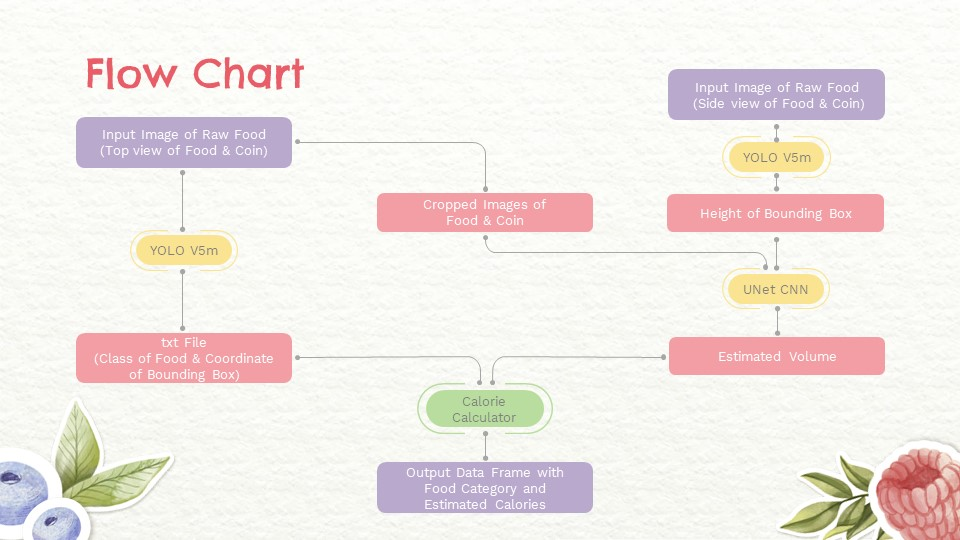

* The input is two images showing the top view of all raw food and side view of meat with a coin as reference object. 
* The top view food image is fed into YOLO for object recognition and localization, and the output is a text file containing label of food and its coordinate of bounding box. 
* Cropped images of meat and coin are fed into a UNet CNN model for area estimation, along with the thickness of meat estimated by the height of bounding box generated from the side view image, the approximated volume of meat is estimated
* Then we will calculate the calories correspondingly for each ingredient and output a summary table.


**Table of Contents:**
1.   Data Collection
2.   Data Cleaning
3.   Object Recognition & Localization 
4.   Image Segmentation 
5.   Volume Estimation
6.   Calories Calculation
7.   Integration on New Data
8.   Related Work
9.   Discussion



# Part 1: Data collection



## 1.1 Fruit and vegetables

**Fruit and Vegetable Dataset**: 
https://www.kaggle.com/kritikseth/fruit-and-vegetable-image-recognition

The dataset contains images of fruits and vegetables, categorized into classes. Only some classes in this dataset was used to reduce training computation. (See Section 1.3 for selected class)   

## 1.2 Meat

For different types of meats, we used a web crawler to collect pictures. The **webCrawler** is an open-source project from Github. The usage is introduced in webCralwer/README.md. The steps are: 
1. Download Chrome 
2. In windows command, use "cd" to where the requirements.txt is, then use "pip install -r requirements.txt". 
3. Write search keywords in keywords.txt 
4. Open the project in PyCharm, then run "main.py"
5.The results will be shown in 'download' directory.  

The result:  


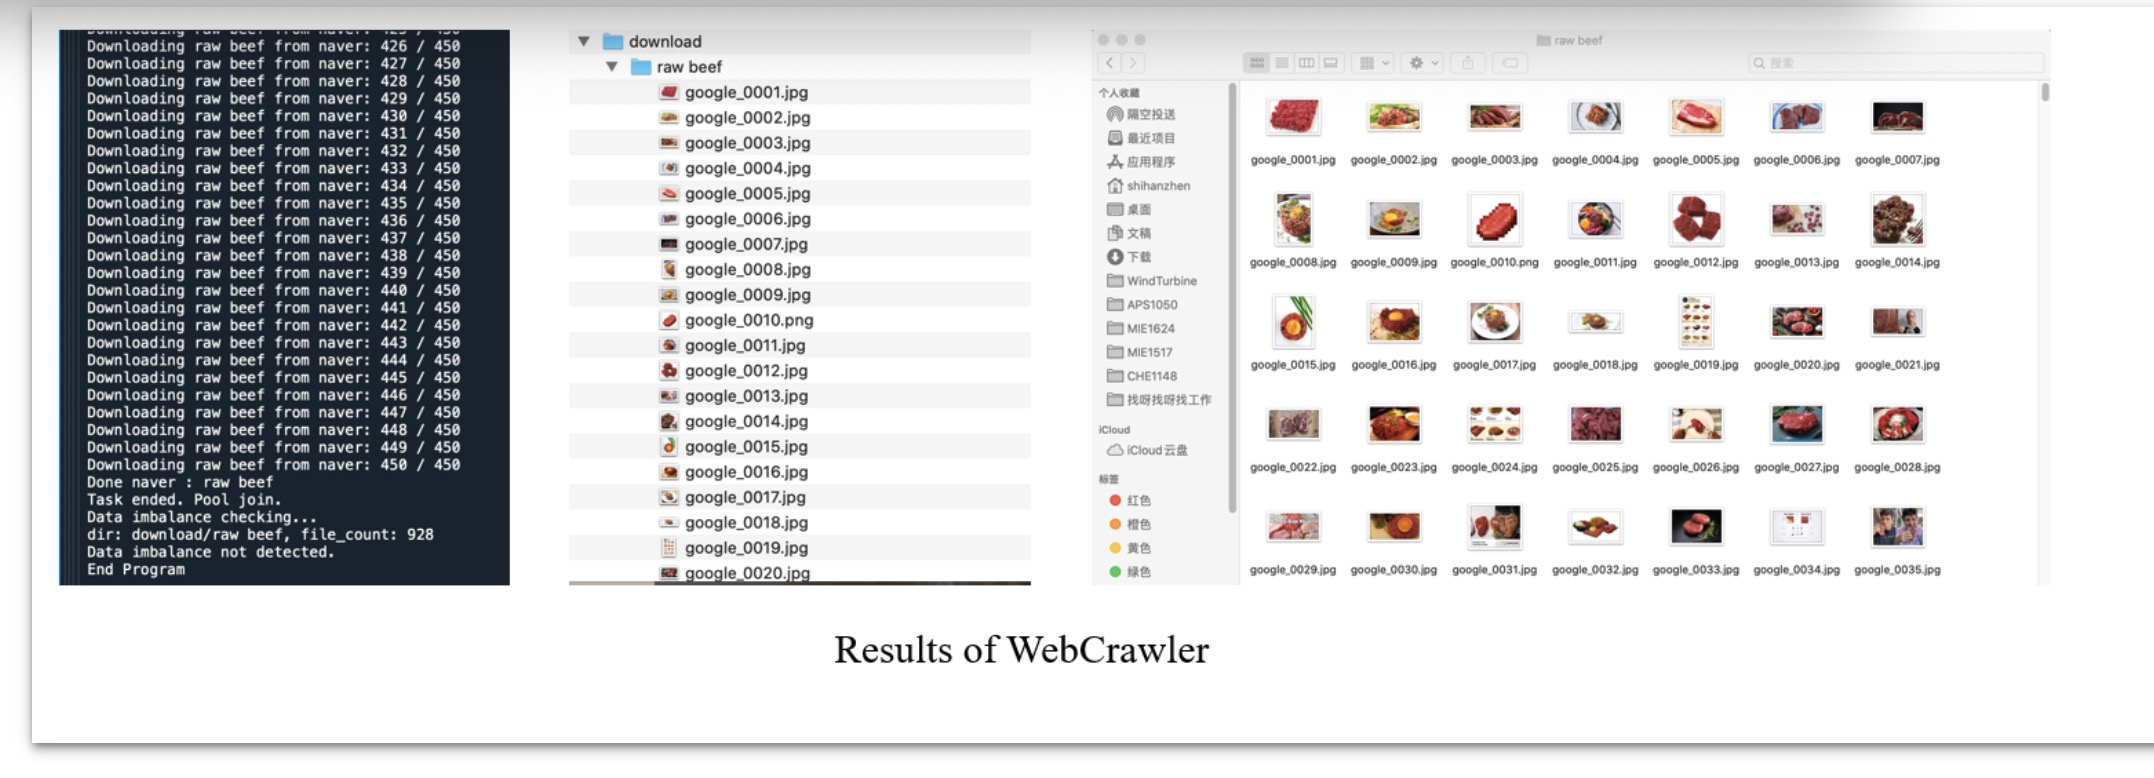

## 1.3 Result (Raw Dataset)
For the scope of this project, we decided to only include objects of the following classes. Each folder contains unlabeled images of its corresponding class.

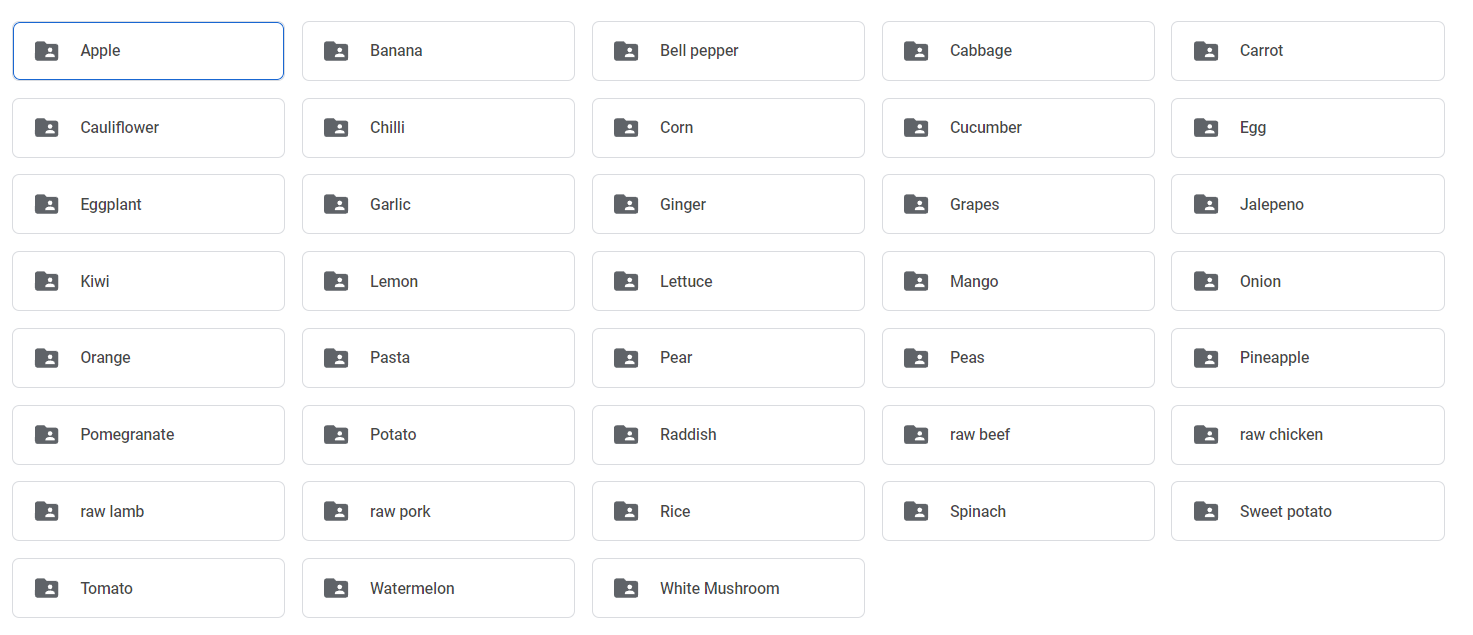

# Part 2: Data cleaning
Now we get enough pictures and they are placed in corresponding files. Now the 2 problems with the dataset are: 
1. Some of the pictures are useless. 
2.Files' names are incorrect. 

So we need to filter pictures and correct the names.


## 2.1 Pictures filtering
The filtering was done manually by the team members. The reasons for dropping a image are:
1. The image contents were wrong (w.r.t. its class).
2. The resolution was too low.


## 2.2 Picture Renaming
We designed the Python script below to automatically correct file names. The codes are included in a separated file named `jpgNameChanger.py`. To use the script, we need to define the path of files in Line8 at first, such as :   
`self.path = r'C:\Users\Will\Desktop\classes\mie1517\project\dataset\raw lamb'`  
And set dst in Line16: 
`dst = os.path.join(os.path.abspath(self.path), 'raw lamb_0000' + format(str(i), '0>3s') + '.jpg')`   
Then the names of jpg files in `'raw lamb'` will be transfer into `'raw lamb_0000xxx'`, like the screenshot shown below:


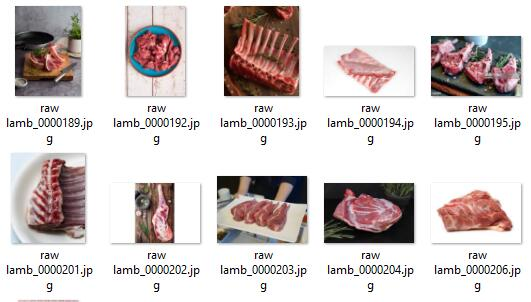

In [ ]:
import os
 
class ImageRename():
    def __init__(self):
        self.path = r'C:\Users\qianq\Desktop\mie1517\project\fruit_vegie_dataset\train\pineapple'
        

    def rename(self):
        filelist = os.listdir(self.path)
        total_num = len(filelist)
        i = 0
        for item in filelist:
           if item.endswith('.jpg'):
               src = os.path.join(os.path.abspath(self.path), item)
               dst = os.path.join(os.path.abspath(self.path), 'pineapple_0000' + format(str(i), '0>3s') + '.jpg')
               os.rename(src, dst)
               print('converting %s to %s ...' % (src, dst))
               i = i + 1
        print('total %d to rename & converted %d jpgs' % (total_num, i))

In [ ]:
start = 1
if start == 1:
    newname = ImageRename()
    newname.rename()

The final image dataset is available through: https://drive.google.com/drive/folders/1b-D7PNRoNijdnprgFR4idXNeWLmVNwre?usp=sharing 

# Part 3. Object Recognition & Localization 

## 3.0 Model Selection
In this project, both localization and recognition of multiple objects are required. YOLOv5m was selected for transfer learning because of its fast processing speed and high accuracy. YOLO struggles with detecting small objects, but in the scenario of this project, the objects' sizes to detect are of similar scales.

The pretrained yolo models are not specialized in detecting foods. Therefore, it is important that we train YOLOv5m on our datasets for better performance.

The management and deployment of YOLO will run in PyCharm, and the following information about YOLO is part of the entire YOLO project code

The architechture of YOLO v5 model is shown in the diagram below.


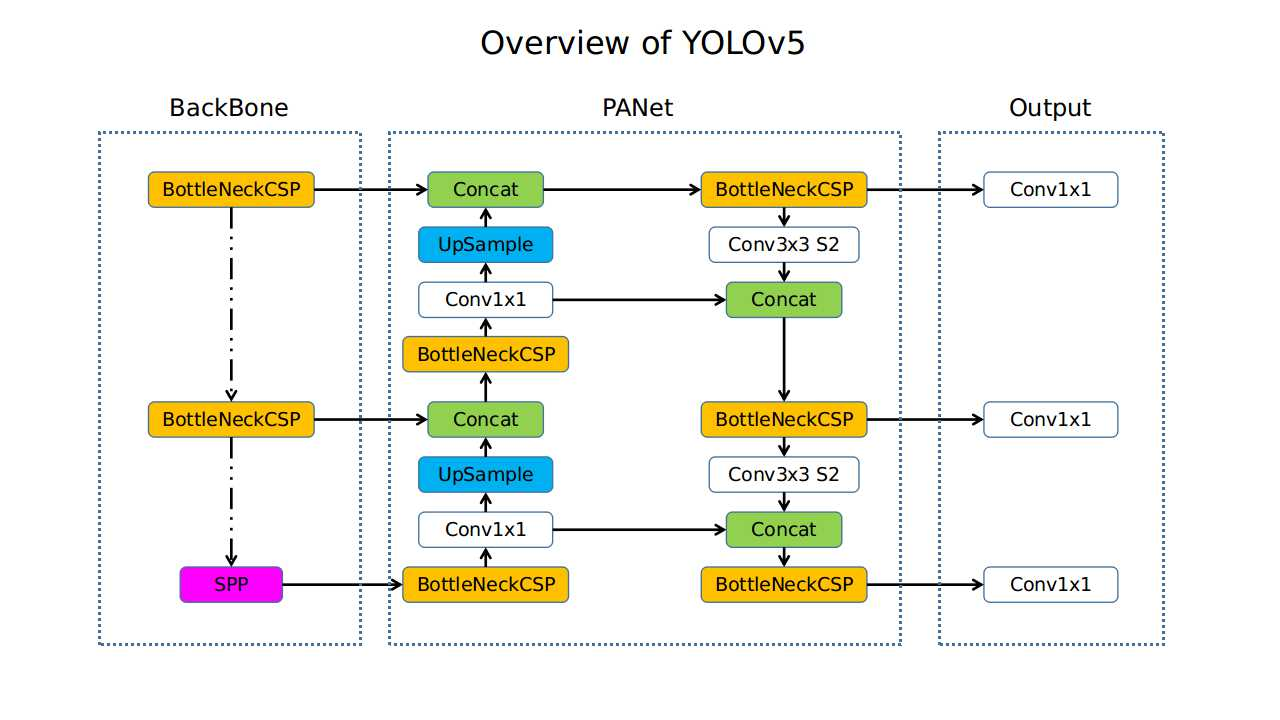

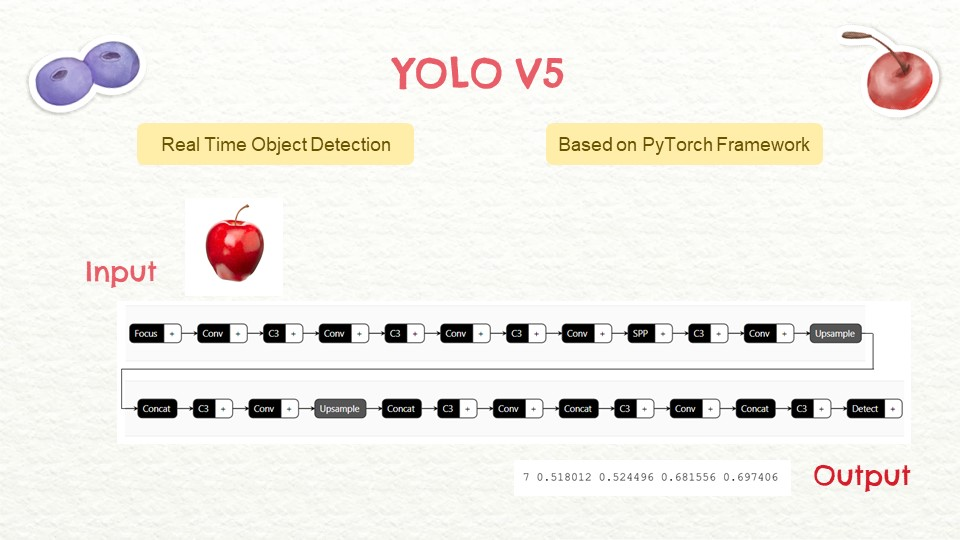

## 3.1 Label Annotation
Since the types of objects to be identified in this project are quite different from those identified in the pre-trained yoloV5 model, the existing model cannot be used for semi-automatic labeling. So we manually annotated 3,500 food photos through Make Sense (https://www.makesense.ai/) and exported the results.  

In Make Sense, we need to upload jpg files and set labels. Then we can start label and export the results in YOLO format. A simple example with only 1 type of label is shown below.  

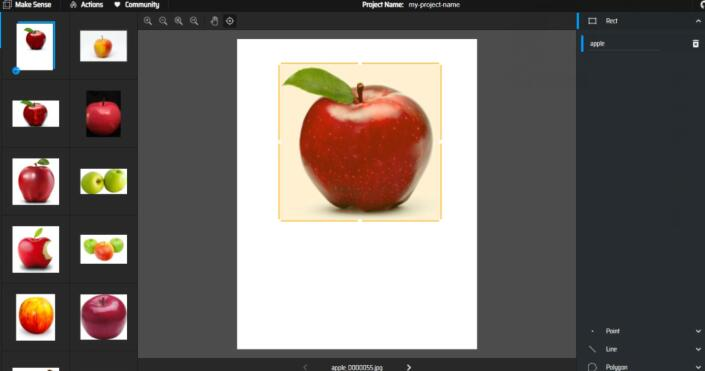

There are some problems with labeling. When all kinds of photos are imported at the same time for labeling, it is difficult to distinguish some meat manually, and it is quite tiring to distinguish the types of objects for a long time. But if we only label 1 type of food each time, the class number in the output txt files will all be 0, which means they are all the same class.  

In order to improve the efficiency, we choose to label 1 type of food each time, then design a script based on python to correct the class. The codes are included in `classChanger.py` with annotation. First, we need to set `label.txt` and the path in `glob.glob("path...")`. Then place `label.txt` and the script in the same dictionary. Next, run the script, and it will automatically modify the categories in the annotation file in enumeration order according to `label.txt`.


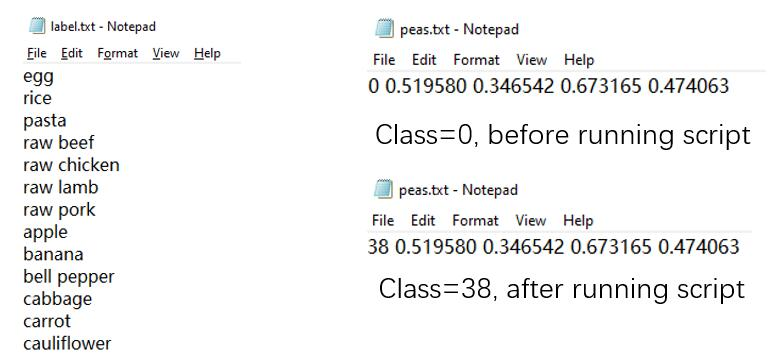

In [ ]:
#code of classChanger.py

import glob

#make label dictionary based on label.txt
labels = []
with open("label.txt", 'r') as f:
    for i in f.readlines():
        labels.append(i.replace('\n', ''))
labelsDictionary = {}
num = 0
for i in labels:
    labelsDictionary[i] = str(num)
    num += 1
print(labelsDictionary)

for filename in glob.glob('labels/**/*.txt', recursive=True):
    for i in labels: #find which class that the image belongs to
        if filename.find(i)!= -1: #start changing the labels
            numReplace = labelsDictionary[i]
            with open(filename, 'r') as f:
                original_lines = f.readlines()
            with open(filename, 'w') as out:
                for line in original_lines:
                    #check if there are more labels in the image
                    if line[1]==" ":
                        newLine = numReplace+line[1:]
                    else:
                        newLine = numReplace + line[2:]
                    out.write(newLine)


The final labels are available through:
https://drive.google.com/drive/folders/1dT8PBLyhpMwbmM9Jo2n3zjEflF4LC7Kr?usp=sharing  

## 3.2 Model Training


First, we need to input the dataset we collected before to YOLO project. The training set includes 2796 samples and validation set includes 783 samples. The proportion is 0.78:0.22.

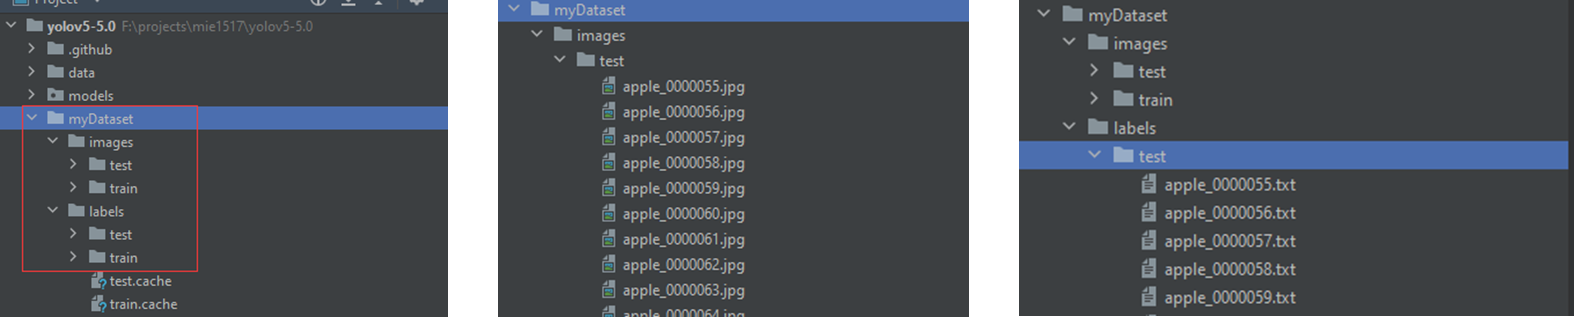

In [ ]:
# Second, we define 'myYOLO.yaml' as data source file
# myYOLO.yaml

# train and val data as 1) directory: path/images/, 2) file: path/images.txt, or 3) list: [path1/images/, path2/images/]
train: myDataset/images/train
val: myDataset/images/test

# number of classes
nc: 49

# class names
names: ['egg', 'rice', 'pasta', 'raw beef', 'raw chicken', 'raw lamb', 'raw pork', 'apple',
        'banana', 'bell pepper', 'cabbage', 'carrot', 'cauliflower', 'chilli', 'corn', 'cucumber',
        'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango',
        'onion', 'orange', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce',
        'mango', 'onion', 'orange', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish',
        'spinach', 'sweet potato', 'tomato', 'watermelon', 'white mushroom','coin']


In [ ]:
# Third, set the parameters in train.py before start training

# This is for first training. 
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--weights', type=str, default='yolov5m.pt', help='initial weights path')
    parser.add_argument('--cfg', type=str, default='models/yolov5m.yaml', help='model.yaml path')
    parser.add_argument('--data', type=str, default='data/myYOLO.yaml', help='data.yaml path')
    parser.add_argument('--hyp', type=str, default='data/hyp.scratch.yaml', help='hyperparameters path')
    parser.add_argument('--epochs', type=int, default=300)
    parser.add_argument('--batch-size', type=int, default=16, help='total batch size for all GPUs') #batchSize
    parser.add_argument('--img-size', nargs='+', type=int, default=[640, 640], help='[train, test] image sizes')
    parser.add_argument('--rect', action='store_true', help='rectangular training')
    .........

# This is for second training. change "--weights"
# Continue training with the model left untrained last time
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--weights', type=str, default='runs/train/exp3/weights/last.pt', help='initial weights path')
    parser.add_argument('--cfg', type=str, default='models/yolov5m.yaml', help='model.yaml path')
    parser.add_argument('--data', type=str, default='data/myYOLO.yaml', help='data.yaml path')
    parser.add_argument('--hyp', type=str, default='data/hyp.scratch.yaml', help='hyperparameters path')
    parser.add_argument('--epochs', type=int, default=300)
    parser.add_argument('--batch-size', type=int, default=16, help='total batch size for all GPUs') #batchSize
    parser.add_argument('--img-size', nargs='+', type=int, default=[640, 640], help='[train, test] image sizes')
    parser.add_argument('--rect', action='store_true', help='rectangular training')
    .........

Then we can start training with 300 epochs. We trained the model locally due to the large amount of computations. **In this project we used 3070Ti GPU and the training duration was 4 hours**. 

The training curve and model performance on different food categories are shown in the diagrams below.

The overall mAP for an IoU threshold of 0.5 is around 65%.  


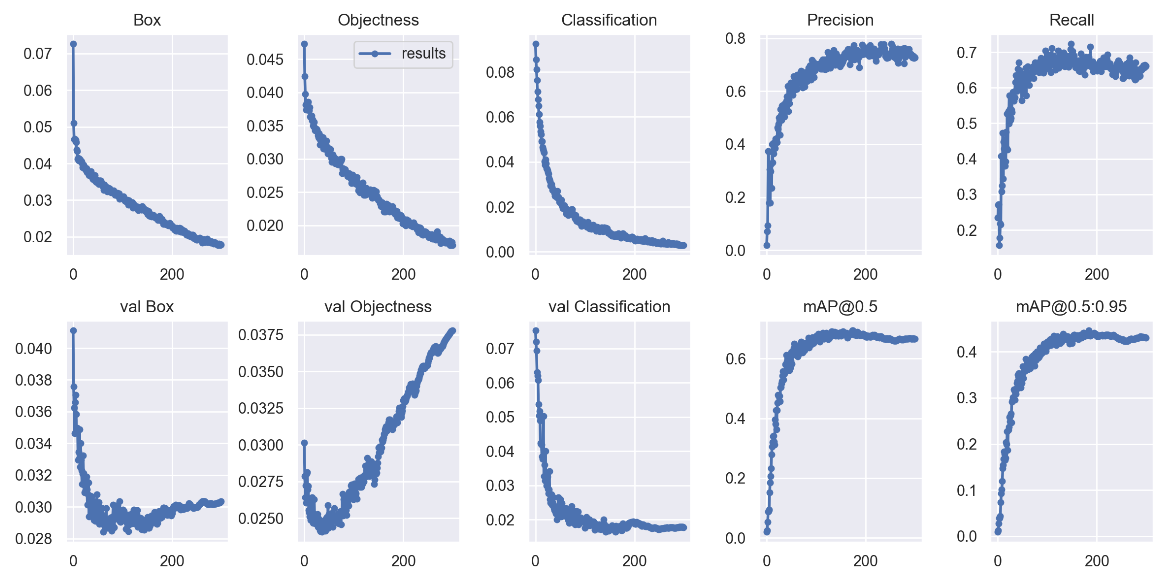

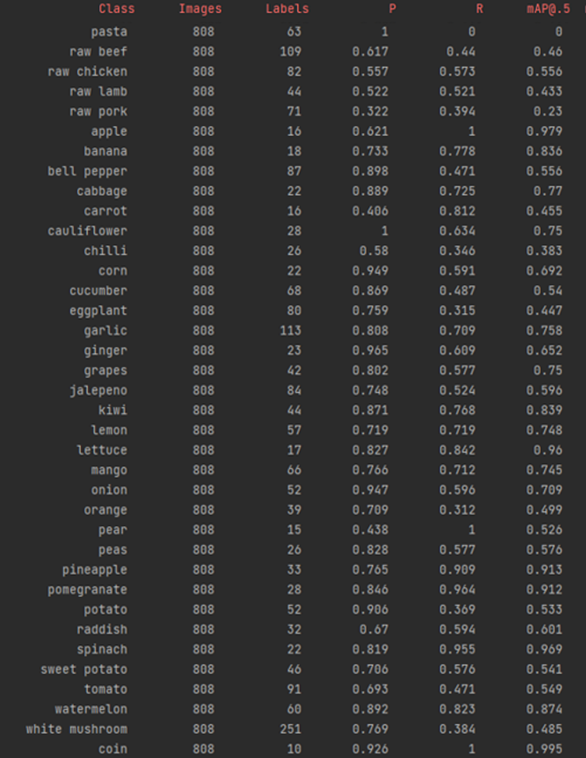

Below are sample images of model performance on validation set.

The model performance varies across different classes. For example, the model is really good at recognizing apples, spinach, and reference coins; while it does poorly on pork and somehow completely fails on pasta. But in general, the model was fairly accurate on most categories when the picture was not so crowded.  

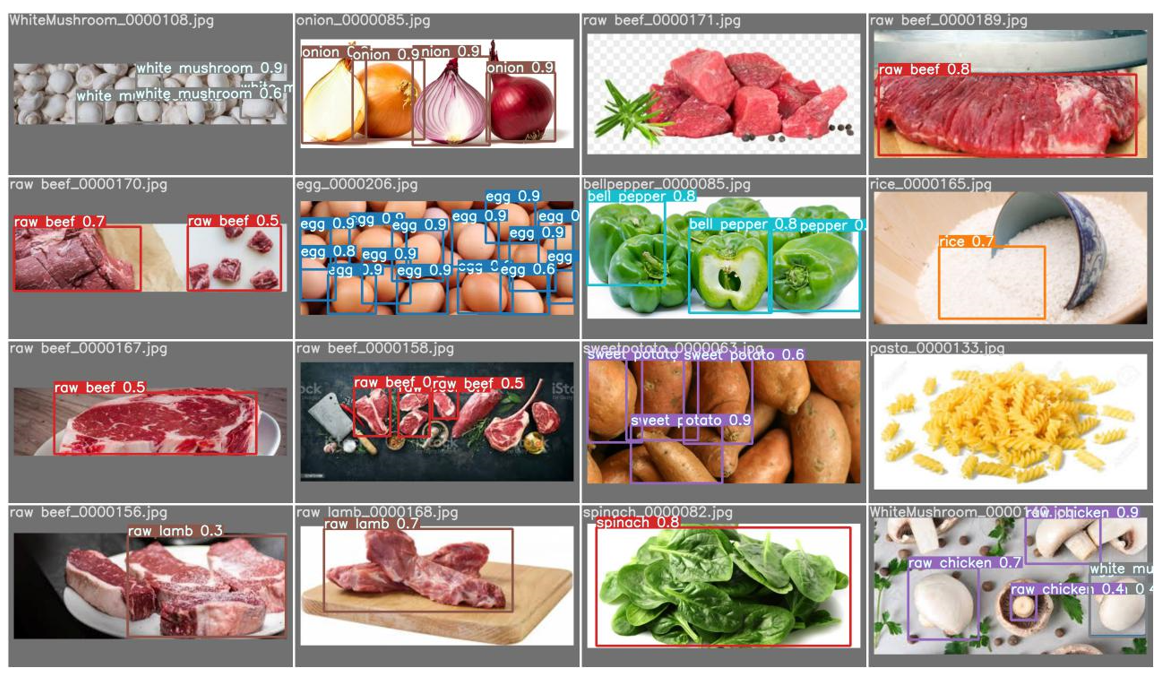

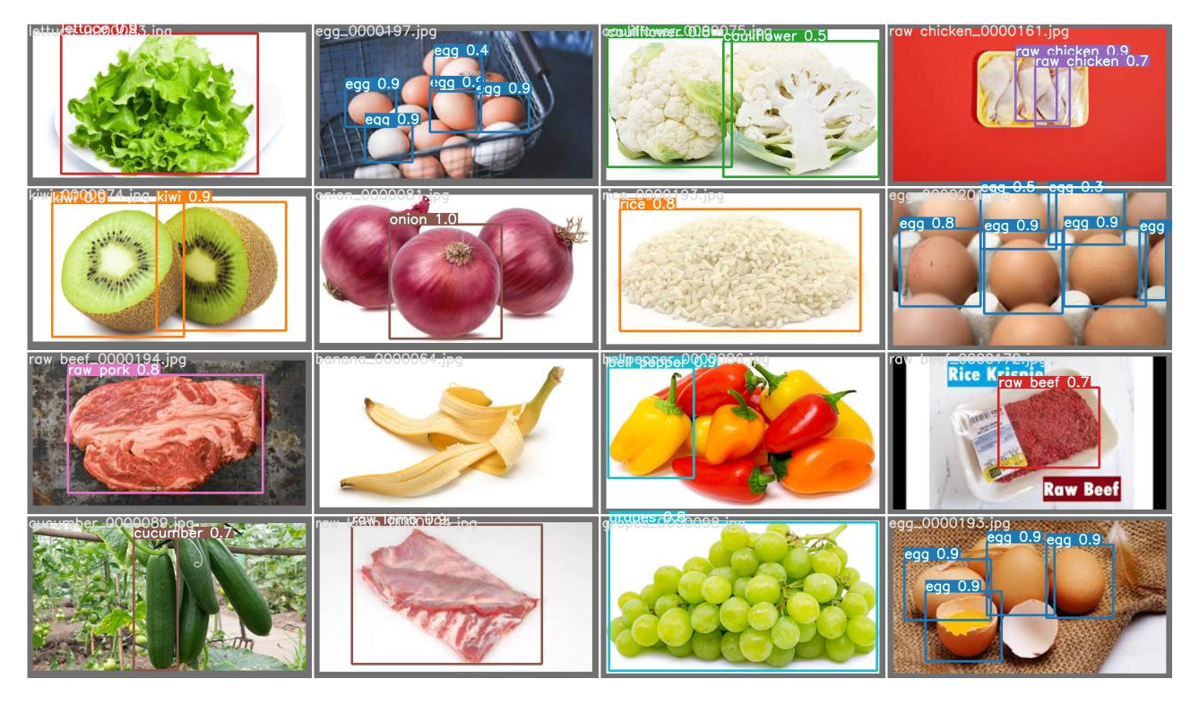

##3.3 Model Usage
Once the model is trained, run detect.py provided by YOLO authors to process the input image for object detection(food). The setting of detect.py is shown below.

In [ ]:
# setting of detect.py in YOLOv5. The main codes are provided by authors.
# training and detecting are done in Pycharm
# run detect.py with parameter: --save-txt
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--weights', nargs='+', type=str, default='runs/train/exp8/weights/last.pt', help='model.pt path(s)')
    parser.add_argument('--source', type=str, default='data/images', help='source')  # file/folder, 0 for webcam
    parser.add_argument('--img-size', type=int, default=640, help='inference size (pixels)')
    parser.add_argument('--conf-thres', type=float, default=0.2, help='object confidence threshold')
    parser.add_argument('--iou-thres', type=float, default=0.45, help='IOU threshold for NMS')
    .........

##3.4 Output Formatting

In [ ]:
# -*- coding: utf-8 -*-
'''
This function is designed to crop images labeled by YOLO, and save 
the info into list for future segmentation

Input:
    Output label files from YOLO, example: xxxxx_0000x.txt
    Original jpg files, example: xxxxx_0000x.jpg
    jpg and txt should be placed in folder, folder relative path = path, such as 'jpg_txt'
    jpg and txt ONLY contain: 1 meat and 1 coin
Output:
    4 list contains the information of cropped jpg and bbox size
'''
def cropImg(path):
    w = 640   #The original size(w,h) of image
    h = 640

    img_total = []
    txt_total = []

    img_meat_top = []
    img_coin_top = []
    meat_bbh_side = []
    coin_bbh_side = []

    file = os.listdir(path)
    for filename in file:
        first,last = os.path.splitext(filename)
        if last == ".jpg":                      # The suffix of the image
            img_total.append(first)
        else:
            txt_total.append(first)

    for img_ in img_total:
        if img_ in txt_total: # Check whether YOLO has output detection results
            filename_img = img_+".jpg"          # The suffix of the original image
            path1 = os.path.join(path,filename_img)
            img = cv2.imread(path1) #Read the original image
            img = cv2.resize(img,(w,h),interpolation = cv2.INTER_CUBIC)   # resize the image, Otherwise, the ROI area may report an error
            filename_txt = img_+".txt" # The name of label.txt
            with open(os.path.join(path,filename_txt),"r+",encoding="utf-8",errors="ignore") as f:
                row = 0 #In the TXT file output by YOLO, the first line is meat and the second line is coin
                for line in f:
                    aa = line.split(" ")
                    aa[-1] = aa[-1][:-2]
                    x_center = w * float(aa[1])       # aa[1] The x-coordinate of the upper left point
                    y_center = h * float(aa[2])       # aa[2] The y-coordinate of the upper left
                    width = int(w*float(aa[3]))       # aa[3] Image width
                    height = int(h*float(aa[4]))      # aa[4] Image height
                    lefttopx = int(x_center-width/2.0)
                    lefttopy = int(y_center-height/2.0)
                    #ROI is the cropped image
                    #[upper left y: lower right y, upper left x: lower right x] (y1:y2,x1:x2) need to be adjusted, otherwise the cropped graph may not be very good
                    roi = img[lefttopy+1:lefttopy+height+3,lefttopx+1:lefttopx+width+1]
                    if row == 0:
                        meat_bbh_side.append(aa[1:5])#Save the bbox size of meat
                        img_meat_top.append(roi)#Save the pictures of meat
                        row += 1
                    else:
                        coin_bbh_side.append(aa[1:5])#Save the bbox size of the coin
                        img_coin_top.append(roi)#Save the picture of coin
        else:
            continue
    return img_meat_top, img_coin_top, meat_bbh_side, coin_bbh_side

**Final model file (YOLOv5m.rar) included in the final submission.**

# Part 4. Image Segmentation

The semantic segmentation section aims to facilitate the volume estimation in Part 5. The reason why we use segmentation after yolo is that we want to take advantages of YOLO's powerful recognition and localization abilities to reduce the complexity of the segmentation model, i.e. **transfer learning**. The original image are cropped into individual close-up shots of each item. To scale down the difficulty, we assume there is no overlap among items such that each item can be cleanly cropped out. Since we already have the item class from YOLO, **this lite version of semantic segmentation model only needs to trace out the outline of the object from the background, regardless of its class.** To further scale down the overall project complexity, we decided to only perform segmentation on meat.

Specifically, we used a skip-connected Net architecture for the semantic segmentation model. The cropped images of meat and the toonie are padded and resized to 224 by 224 pixels while maintaining the proportion in the original image. These RGB images are the inputs of the UNet. The outputs are corresponding binary masks. We can then use the number of pixels of meat and the toonie in the masks to compute the actual area by referencing the actual size of toonies, which is 28mm*28mm.


In [ ]:
import matplotlib.pyplot as plt

import numpy as np
import numpy.random as npr

import time
import argparse
import math
import numbers
import os
import json

!pip install opencv-python
import cv2

import PIL
from PIL import Image
import imageio

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision.transforms.functional import pad
from torch.autograd import Variable

## 4.1 Model Architecture



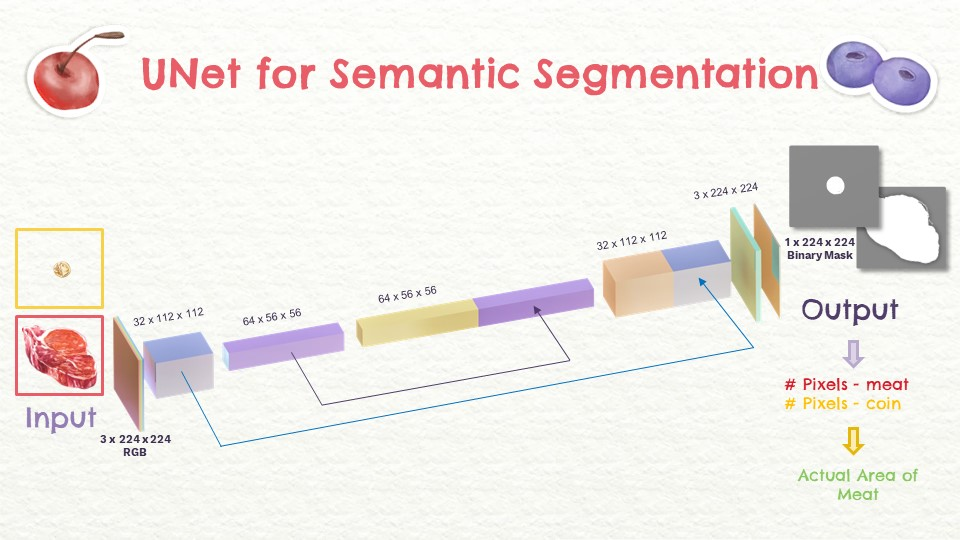

In [ ]:
class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=1, num_in_channels=3):
        super().__init__()
        self.name = "UNet"

        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### Architecture ############### 
        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),)

        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*4, num_filters, kernel_size=kernel, padding=padding, stride=stride, output_padding=output_padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),)
            
        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*2, num_colours*3, kernel_size=kernel, padding=padding, stride=stride, output_padding=output_padding),
            nn.BatchNorm2d(num_colours*3),
            nn.ReLU(),)

        self.finalconv = nn.Conv2d(num_colours*3, num_colours, kernel_size=kernel, padding=padding)

    def forward(self, x):
        layer1 = self.downconv1(x)
        layer2 = self.downconv2(layer1)
        out = self.rfconv(layer2)
        out = self.upconv1(torch.cat((out, layer2),1))
        out = self.upconv2(torch.cat((out, layer1),1))
        out = self.finalconv(out)
        return out

In [ ]:
!pip install torchsummary
from torchvision import models
from torchsummary import summary

model_disp = UNet(3,32)
summary(model_disp,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,496
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,928
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
  ConvTranspose2d-12         [-1, 32, 112, 112]          36,896
      BatchNorm2d-13         [-1, 32, 112, 112]              64
             ReLU-14         [-1, 32, 1

## 4.2 Dataset Preparation

### 4.2.1 Label Annotation

Training set containing 263 images(41 coin images and 222 meat images) were manually annotated using Make Sense (https://www.makesense.ai/) .  

In Make Sense, we need to upload jpg files (training data)and set labels. Then we can start label and export the results in JSON format. Polygon bounding box shape was used to outline the shape of meat and coin. A simple example with only 1 type of label(beef) is shown below.  

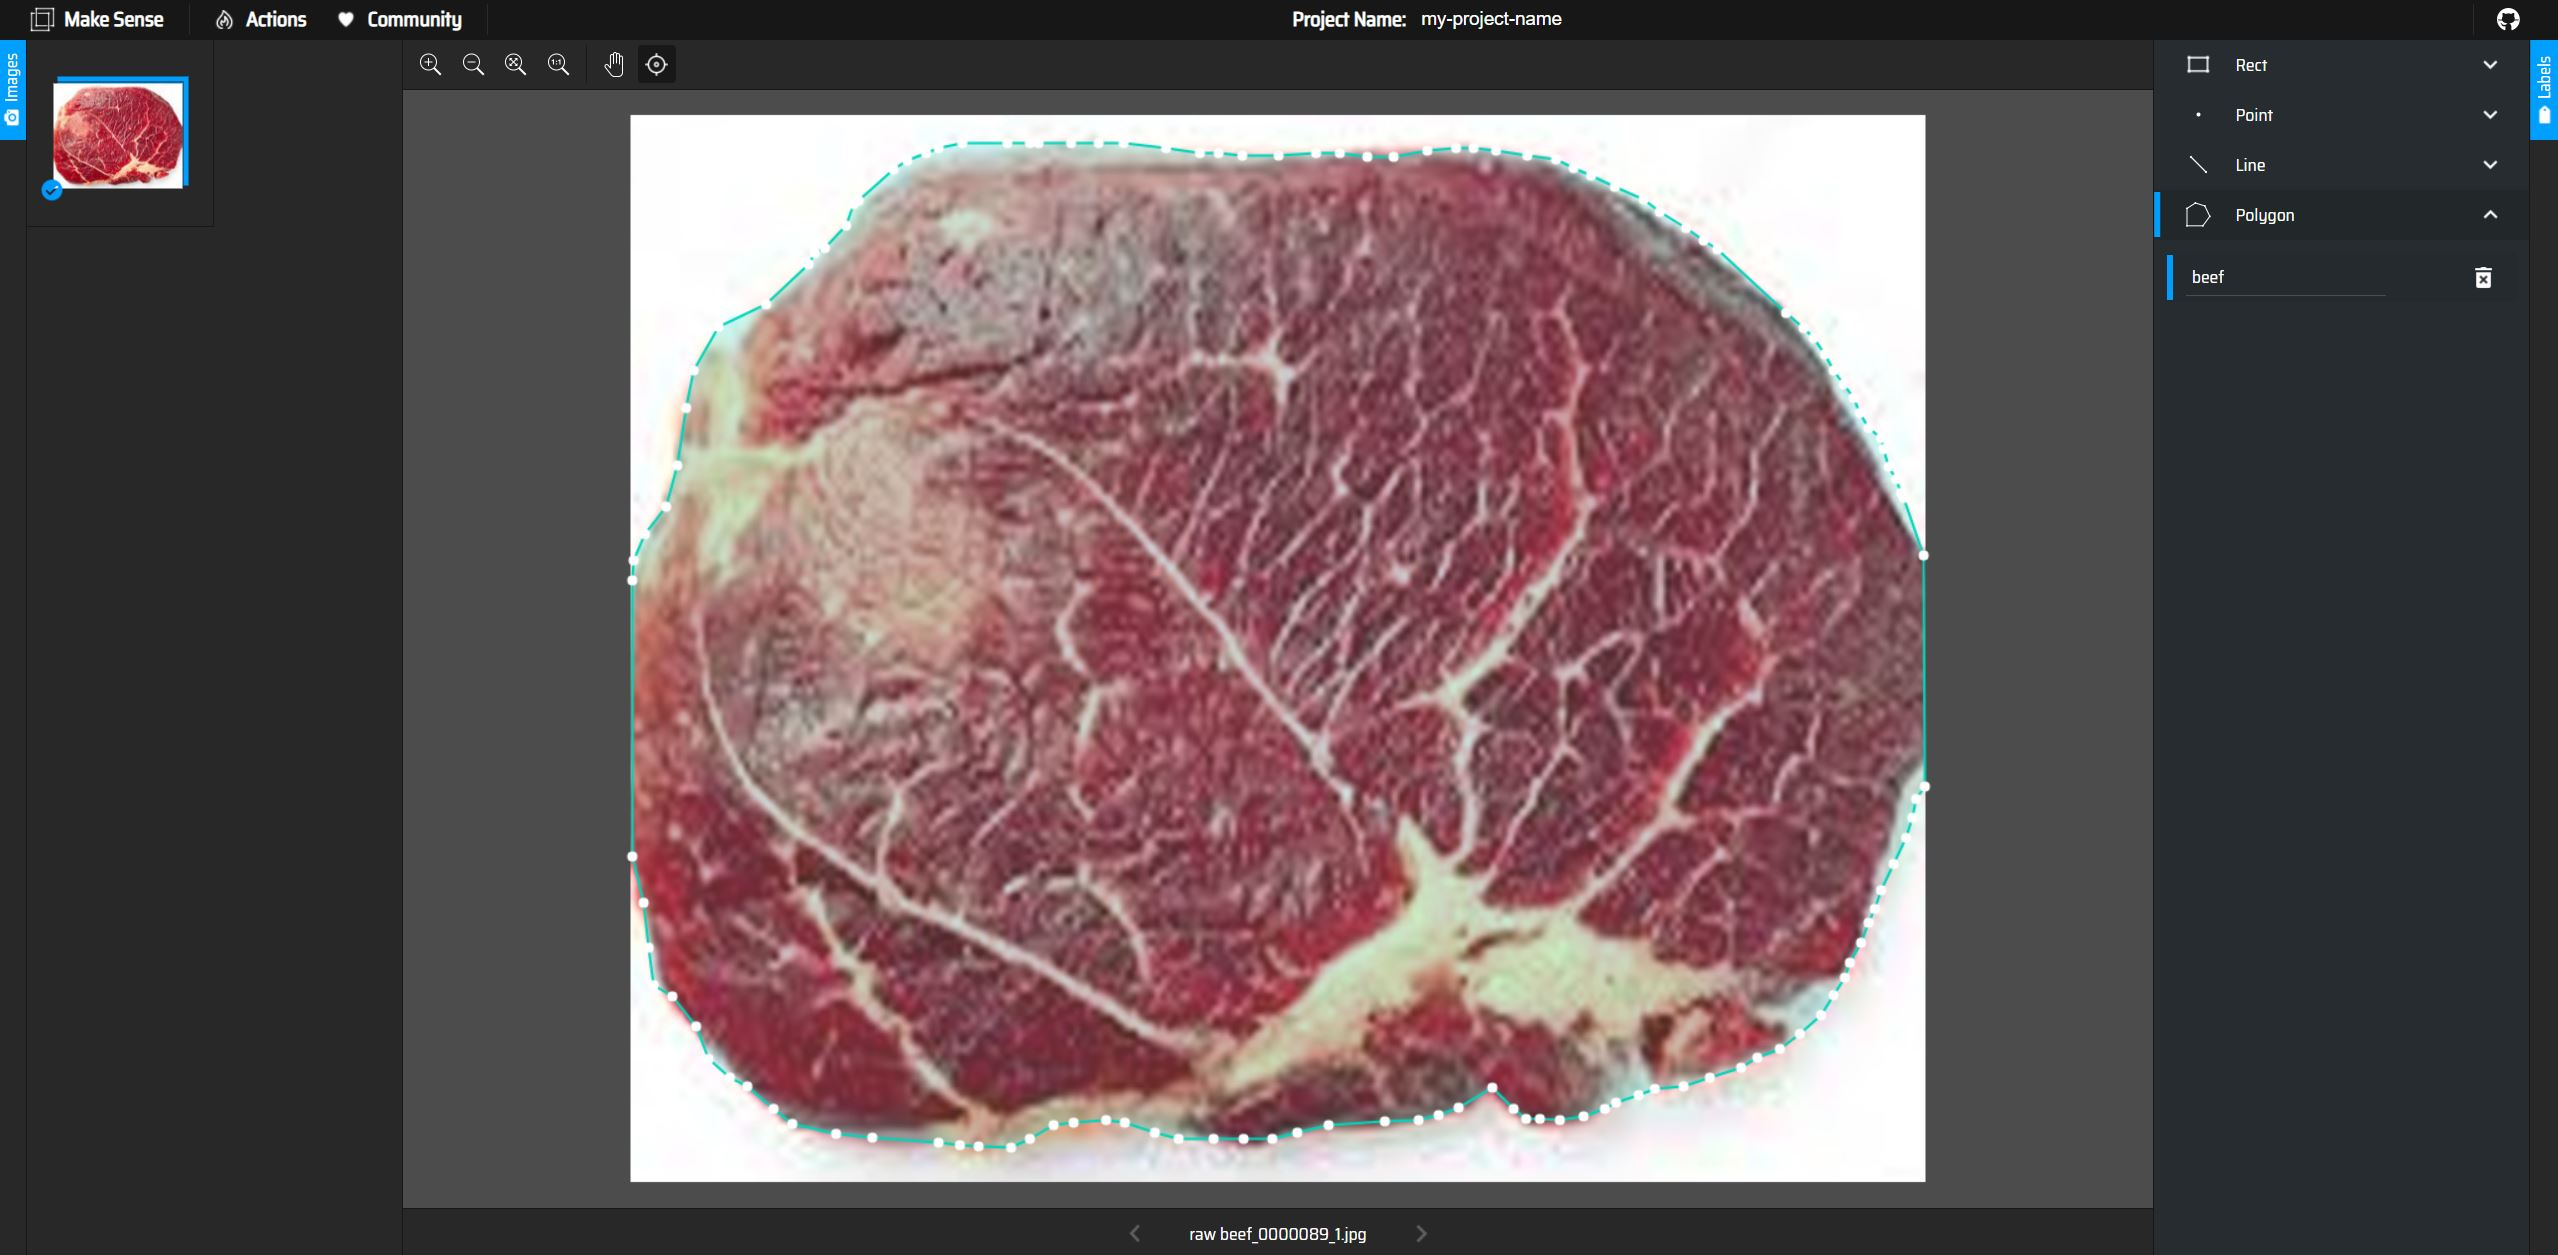


Below is an example(beef) of the output JSON file which contains information of all the image labels including corresbonding image file name, the coordinates of all the points on the polygon bounding boxes. The JSON file is then used to generate target binary mask for UNet training.


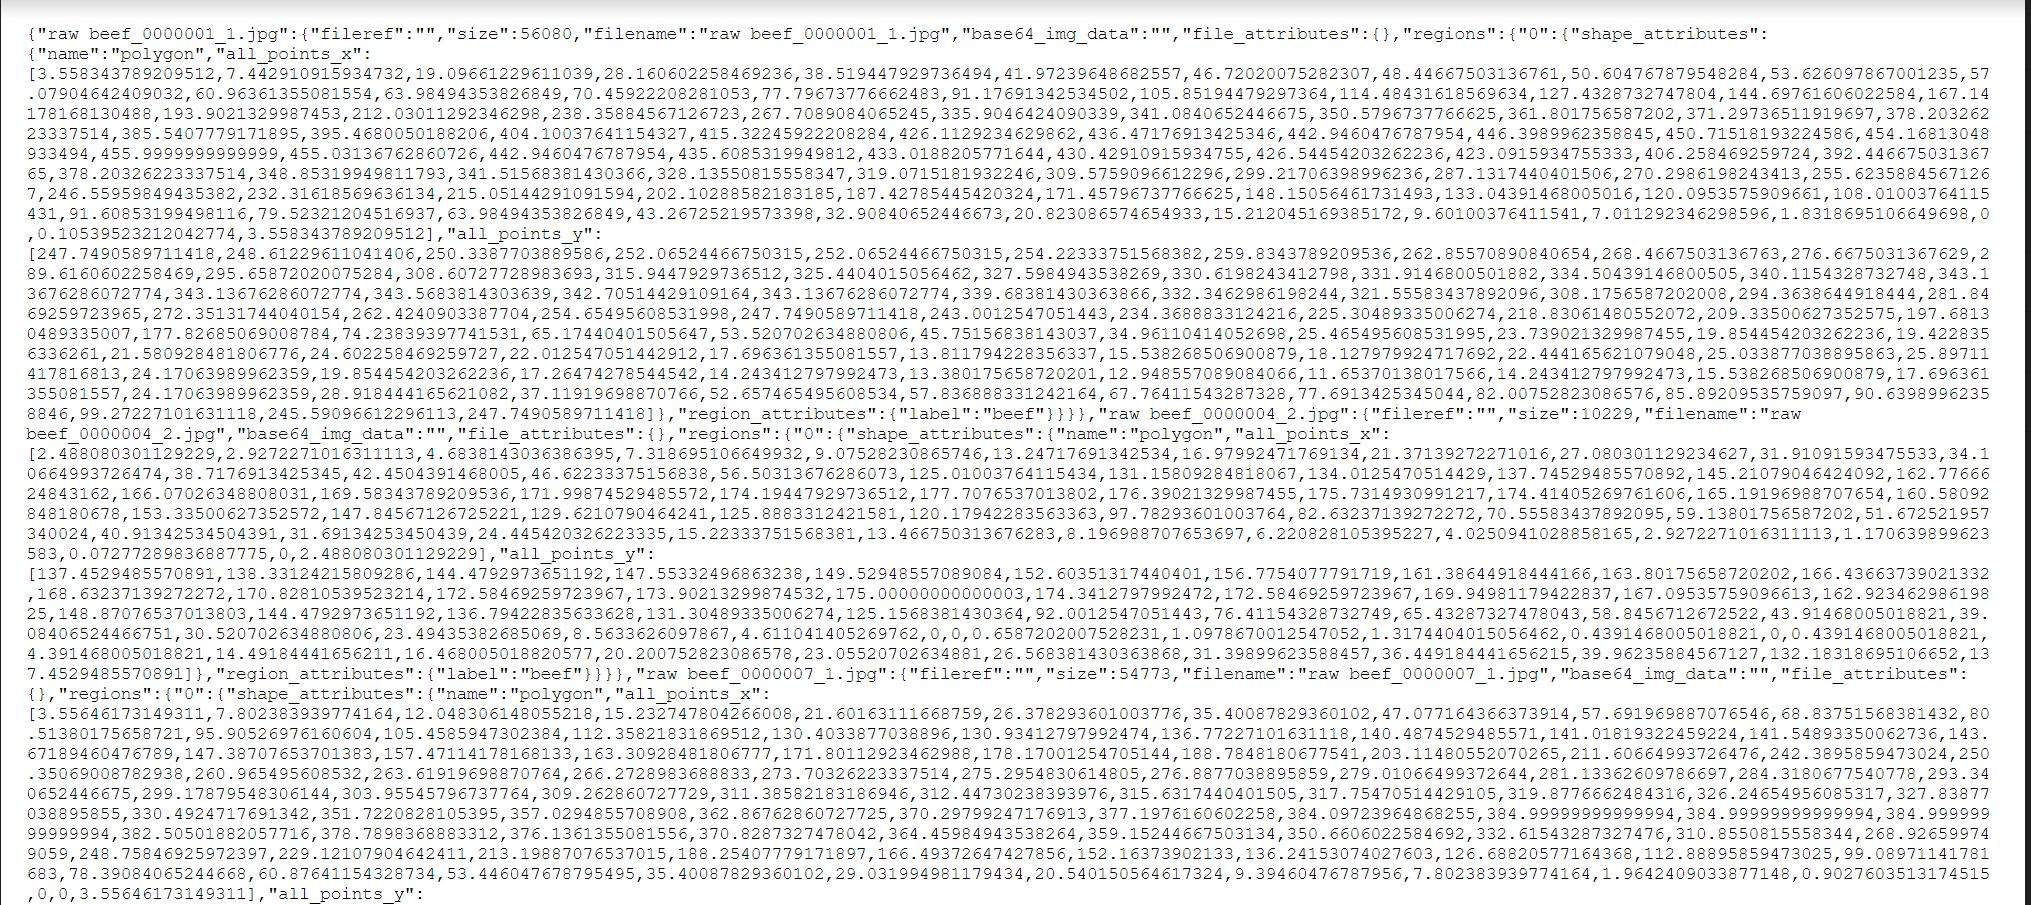

Note the output format should be "VGG JSON".

### 4.2.2 JSON to Binary Mask

The code below generates binary masks from the JSON label file.

To use, change the directory in the cell below. The `source_folder` contains all images corresponding to the labels in the JSON file. `json_path` is the directory of the JSON file. `mask_folder` is the target folder to save the generated masks. Note each mask will have the same filename as its corresponding image.

Adapted from https://towardsdatascience.com/generating-image-segmentation-masks-the-easy-way-dd4d3656dbd1

In [ ]:
########################################################################
#change the path below before running next file

# path of the folder of images
source_folder = os.path.join(os.getcwd(), "toonie")
# path of the json file
json_path = "toonie.json"  
# path of the folder to save generated masks
mask_folder = 'C:\\Users\\qianq\\Desktop\\mie1517\\project\\labels_toonie'
########################################################################

In [ ]:
# Open JSON file and return JSON object as a dictionary
f = open(json_path) 
data = json.load(f) 
img_lst = list(data.keys()) # name list of all images inside folder

# Extract X and Y coordinates if available and update dictionary
def add_to_dict(data, itr, key, count):
    try:
        x_points = data[itr]["regions"]['0']["shape_attributes"]["all_points_x"]  
        y_points = data[itr]["regions"]['0']["shape_attributes"]["all_points_y"]
    except:
        print("No objects. Skipping", key)
        return

    all_points = []

    for i, x in enumerate(x_points):
        all_points.append([x, y_points[i]])

    file_bbs[key] = all_points
    return

print('Image Source folder:',source_folder)
print('VGG format json label:',json_path)
print('Mask folder:',mask_folder)
print('Generating', len(img_lst), 'masks from json...')

# every image in the image folder
for img in img_lst:
    img_data = {}
    img_data[img] = data[img]    
    file_bbs = {}                                       # Dictionary containing polygon coordinates for mask
    count = 0                                           # Count of total images saved
    
    image = Image.open(os.path.join(source_folder, img))
    MASK_WIDTH, MASK_HEIGHT = image.size                # Dimensions should match those of ground truth image


    for itr in img_data:
        file_name_json = img_data[itr]["filename"]
        sub_count = 0               # Contains count of masks for a single ground truth image

        if len(img_data[itr]["regions"]) > 1:
            for _ in range(len(data[itr]["regions"])):
                key = file_name_json[:-4] + "*" + str(sub_count+1)
                add_to_dict(img_data, itr, key, sub_count)
                sub_count += 1
        else:
            add_to_dict(img_data, itr, file_name_json[:-4], 0)

    # For each entry in dictionary, generate mask and save in correponding folder
    for itr in file_bbs:
        num_masks = itr.split("*")
        mask = np.zeros((MASK_HEIGHT, MASK_WIDTH))
        try:
            arr = np.array(file_bbs[itr])
        except:
            print("Not found:", itr)
            continue
        count += 1
        cv2.fillPoly(mask, np.int32([arr]), color=(255))
        
        mask = mask.astype(np.uint8)

        if len(num_masks) > 1:
            imageio.imwrite(os.path.join(mask_folder, itr.replace("*", "_") + ".jpg") , mask)    
        else:
            imageio.imwrite(os.path.join(mask_folder, itr + ".jpg") , mask)

print('Done!')

Image Source folder: C:\Users\qianq\Desktop\mie1517\project\toonie
VGG format json label: toonie.json
Mask folder: C:\Users\qianq\Desktop\mie1517\project\labels_toonie
Generating 41 masks from json...
Done!


### 4.2.3 Image & Mask Resizing and Padding
The following functions pad an image and its labels to square shape (or custom size) and resize to 224*224 (optional). They are helper codes for section 4.2.4 and section 4.2.5. You can have a preview of what they do by calling them alone. An example is included.

Adapted from https://discuss.pytorch.org/t/how-to-resize-and-pad-in-a-torchvision-transforms-compose/71850 

In [ ]:
def get_padding(image, custom_size=None):    
    """
    input: 
          image: image to be padded
          custom_size: (w,h) of desirable size
          
    output: 
          padding: seq, in in torchvision.transforms.Pad format
                   if no custom_size specified, the value is for padding the image to square shape
    """

    if custom_size != None:
        w, h = image.size
        max_wh = np.max(custom_size) #target length = the larger one between original width and height
        
    else:
        w, h = image.size
        max_wh = np.max([w, h])
        
    h_padding = (max_wh - w) / 2
    v_padding = (max_wh - h) / 2
    l_pad = h_padding if h_padding % 1 == 0 else h_padding+0.5
    t_pad = v_padding if v_padding % 1 == 0 else v_padding+0.5
    r_pad = h_padding if h_padding % 1 == 0 else h_padding-0.5
    b_pad = v_padding if v_padding % 1 == 0 else v_padding-0.5
    padding = (int(l_pad), int(t_pad), int(r_pad), int(b_pad))
        
    return padding

# define a transform to convert a tensor to PIL image
tensor2image = transforms.ToPILImage()
#image_new = tensor2image(tensor)

In [ ]:
def image_processing (img, label, custom_padding=None, RESIZE=True):
    """
    input: 
          img, label: RGB image and its label (binary mask), same shape
          custom_padding: sequence, in torchvision.transforms.Pad format
          RESIZE: boolean, whether to resize images
          
    output: 
          image_new, label_new: image and label padded (and resized to 224*244 RGB if RESIZE)
          size: size after padding but before resizing, for maintaining proportion of different cropped images
    """

    if custom_padding != None:
        padding = custom_padding
    else:
        padding = get_padding(img)
    
    # Define transforms to convert the image to tensor
    pad_tf = transforms.Pad(padding=padding, fill=0, padding_mode='constant')
    resize_tf =  transforms.Resize((224,224))
    
    # process the image 
    image_new = pad_tf(img)
    label_new = pad_tf(label)
    
    size = image_new.size #size after padding, before resizing
    
    if RESIZE:
        image_new = resize_tf(image_new)
        label_new = resize_tf(label_new)
    
    return (image_new, label_new), size

In [ ]:
# example
image = Image.open('raw_beef_0000157.jpg')
label = Image.open('raw_beef_0000157_mask.jpg')

(image_new, label_new), xx = image_processing (image, label)

In [ ]:
print("original image size", image.size)
print("processed image size", xx)
print("final image size", image_new.size)

original image size (275, 183)
processed image size (275, 275)
final image size (224, 224)


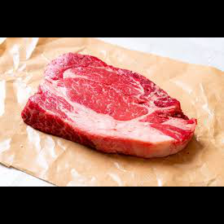

In [ ]:
image_new

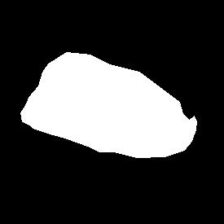

In [ ]:
label_new

### 4.2.4 Special handeling of tonnie images/masks
During actual use scenario, the cropped toonie image will be much smaller than cropped meat. 
Need to downsize the web toonie images for training by padding more so the toonie will be smaller when resized to 224*224. 

The width or length of each toonie will be randomly padded to 3~6 times of its original value.

In [ ]:
*# change directory here
########################################################################################
image_folder = os.path.join(os.getcwd(), "toonie") # directory of toonie images 
mask_folder = 'C:\\Users\\qianq\\Desktop\\mie1517\\project\\labels_toonie' # directory of masks

resized_img_folder = 'C:\\Users\\qianq\\Desktop\\mie1517\\project\\toonie_r'
resized_msk_folder = 'C:\\Users\\qianq\\Desktop\\mie1517\\project\\labels_toonie_r'
########################################################################################

img_lst = os.listdir(image_folder)
label_lst = os.listdir(mask_folder)

#check image and target are one-to-one with the same file name
assert (img_lst == label_lst), "Mismatch of data and target!"

print('Original toonie image folder:',image_folder)
print('Original toonie mask folder:',mask_folder)
print('Save to:', resized_img_folder,'   ', resized_msk_folder)
print('Resizing', len(img_lst), 'images and masks...')

for img_name in img_lst:
    image = Image.open(os.path.join(image_folder, img_name))
    label = Image.open(os.path.join(mask_folder, img_name))
    w, h = image.size
    w = np.rint(w*npr.uniform(3,6)) #randomly size up (3<=factor<=6) 
    h = np.rint(h*npr.uniform(3,6))
    (image_new, label_new), _ = image_processing (image, label, custom_padding=get_padding(image, custom_size=(w,h)), RESIZE=False)
    imageio.imwrite(os.path.join(resized_img_folder, img_name) , image_new)
    imageio.imwrite(os.path.join(resized_msk_folder, img_name) , label_new)
    # The images will be long rectangles.
    # They will be padded to square and resized to model input dimension later.
print('Done!')

Original toonie image folder: C:\Users\qianq\Desktop\mie1517\project\toonie
Original toonie mask folder: C:\Users\qianq\Desktop\mie1517\project\labels_toonie
Save to: C:\Users\qianq\Desktop\mie1517\project\toonie_r     C:\Users\qianq\Desktop\mie1517\project\labels_toonie_r
Resizing 41 images and masks...
Done!


### 4.2.5 Dataset Loading

`image_folder` is a single folder containing all training images (regarless of class). 
`mask_folder` is a single folder containing all masks corresponding to the images in `image_foldr`. Note each image is matched with a mask with the same name.

The following code transforms all images and masks to input format and convert to tensors. `X` stores all image tensors and `y` stores all mask tensors.

Then we split them to train set, validation set, and test set using ratio of `0.8:0.1:0.1`. The data are now ready to be trained and tested on.

Detailed instructions on how to use the dataset please see Section 4.2 helper codes.

Dataset available through:  https://drive.google.com/file/d/13FJa63tBBF6fmT2K4Cf3EyyLwyitLYln/view?usp=sharing 

**Final model state file included in the final submission.**

In [ ]:
# change directory here
########################################################################################
image_folder = os.path.join(os.getcwd(), "segmentation_dataset\\Images") # directory of images 
mask_folder = 'C:\\Users\\qianq\\Desktop\\mie1517\\project\\segmentation_dataset\\Labels' # directory of masks
########################################################################################

img_lst = os.listdir(image_folder)
label_lst = os.listdir(mask_folder)

#check image and target are one-to-one with the same file name
assert (img_lst == label_lst), "Mismatch of data and target!"

X = [] #list of tensors
y = [] #list of tensors
img2tensor = transforms.ToTensor()

for img_name in img_lst:
    image = Image.open(os.path.join(image_folder, img_name))
    label = Image.open(os.path.join(mask_folder, img_name))
    (image_new, label_new), _ = image_processing (image, label)
    tensor_img = img2tensor(image_new)
    tensor_label = img2tensor(label_new)
    X.append(tensor_img)
    y.append(tensor_label)
    
# Split (train:val:test = 0.8:0.1:0.1)
X_train, X_m, y_train, y_m = train_test_split(X, y, test_size=0.2, random_state=6)
X_val, X_test, y_val, y_test = train_test_split(X_m, y_m, test_size=0.5, random_state=6)

## 4.2 Model Training

In [ ]:
# Helper Codes:
def get_dataloader (X_train, y_train, X_val, y_val, X_test, y_test, batch_size=32):
    """ Generate a dataloader for each set 

    Args:
        X_train, y_train, X_val, y_val, X_test, y_test: datasets from section 4.2.5
        batch_size: custom batch size, default 32
    Returns:
        dataloaders
    """
    train_set = torch.utils.data.TensorDataset(torch.stack(X_train),torch.stack(y_train))
    val_set = torch.utils.data.TensorDataset(torch.stack(X_val),torch.stack(y_val))
    test_set = torch.utils.data.TensorDataset(torch.stack(X_test),torch.stack(y_test))
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader

def get_model_name(args, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_kernal{1}_num_filters{2}_bs{3}_lr{4}_epoch{5}".format(args.model,
                                                                            args.kernel,
                                                                            args.num_filters,
                                                                            args.batch_size,
                                                                            args.learn_rate,
                                                                            epoch)
    return path

def get_accuracy(model, dataloader, use_cuda):
    """ Calculate the pixel-wise accuracy 

    Inputs: model and dataloader to get accuracy for; 
            use_cuda: boolean, whether to use gpu
    Output: the average accuracy on all batches in the dataloader
    """
    acc_bet_batch = []
    for imgs, labels in dataloader: #batch level
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        #############################################
             
        output = model(imgs)
        sigmoid = nn.Sigmoid()    #externally apply sigmoid
        output = sigmoid(output)
        
        acc_in_batch = []
        for i in range(imgs.shape[0]): #image level
            out = output[i]
            pred = out.masked_fill_(out>=0.5, 1)      # prob>=0.5, pixel = 1
            pred = pred.masked_fill_(pred<0.5, 0)     # prob<0.5, pixel = 0
            correct = pred.eq(labels[i].view_as(pred)).sum().item()
            acc =  correct/(224*224)                  # acc of this image
            acc_in_batch.append(acc) 
            
        acc_batch = np.mean(acc_in_batch)    
        acc_bet_batch.append(acc_batch)
        
    return np.mean(acc_bet_batch)

class AttrDict(dict):  #for storing model hyperparameters
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to move the tensors to GPU,
    if GPU is used.

    Args:
      xs (pytorch tensor): rgb tensor input
      ys (pytorch tensor): binary mask as labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

### 4.2.1 Training

In [ ]:
def train(args, gen=None):

    # random seed
    torch.manual_seed(args.seed)
    
    ########################################################################
    # Save directory
    save_dir = os.path.join(os.getcwd(), "outputs/") 
    ########################################################################

    # LOAD THE MODEL
    if gen is None:
        Net = globals()[args.model]
        gen = Net(args.kernel, args.num_filters)

    # LOSS FUNCTION
    criterion = nn.BCEWithLogitsLoss()    #binary mask
    optimizer = optim.Adam(gen.parameters(), lr=args.learn_rate)

    # DATA LOADER
    print("Loading data...") 
    train_loader, val_loader, _ = get_dataloader(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=args.batch_size)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...",'\n')
    if args.gpu:
        gen.cuda()
    start_time = time.time()

    train_acc = []
    valid_losses = []
    valid_accs = []
    losses, train_acc, val_acc = [], [], []
    for epoch in range(args.epochs):
        # Train the Model
        gen.train()  # Change model to 'train' mode
        for i, (xs, ys) in enumerate(train_loader): #batch level
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = gen(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())
           
        # compute training accuracy and validation accuracy at end of each epoch
        train_acc.append(get_accuracy(gen, train_loader, args.gpu))           
        val_acc.append(get_accuracy(gen, val_loader, args.gpu))  
        
        print(("Epoch {}: Train acc: {}, Train loss: {} | Validation acc: {}").format(
            epoch + 1, train_acc[-1], losses[-1], val_acc[-1],))
    
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(args, epoch)
        torch.save(gen.state_dict(), os.path.join(save_dir, model_path))
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print('\n')
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~Finished Training~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(train_acc, label="Train")
    plt.plot(val_acc, label="Validation")
    plt.legend(loc='best')
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.show()
    
    return gen

Loading data...
Beginning training ... 

Epoch 1: Train acc: 0.7467986101620708, Train loss: 0.6027600169181824 | Validation acc: 0.7779079179748821
Epoch 2: Train acc: 0.8212441412576935, Train loss: 0.5690470933914185 | Validation acc: 0.8242747068779436
Epoch 3: Train acc: 0.862414795950002, Train loss: 0.5346109867095947 | Validation acc: 0.8435805963010204
Epoch 4: Train acc: 0.8668077751236283, Train loss: 0.5025405287742615 | Validation acc: 0.8424767893936421
Epoch 5: Train acc: 0.8707337671396684, Train loss: 0.47367188334465027 | Validation acc: 0.8468460250686815
Epoch 6: Train acc: 0.8756725532474895, Train loss: 0.4463956356048584 | Validation acc: 0.8553645015698587
Epoch 7: Train acc: 0.8778163364955358, Train loss: 0.42191892862319946 | Validation acc: 0.8607838868720565
Epoch 8: Train acc: 0.8801558098825468, Train loss: 0.39967015385627747 | Validation acc: 0.8650780023547882
Epoch 9: Train acc: 0.8850005322534521, Train loss: 0.37866005301475525 | Validation acc: 0.8

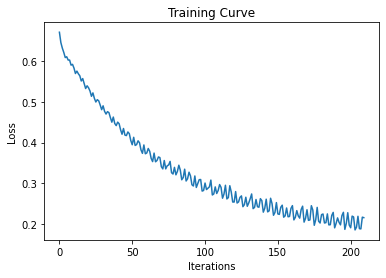

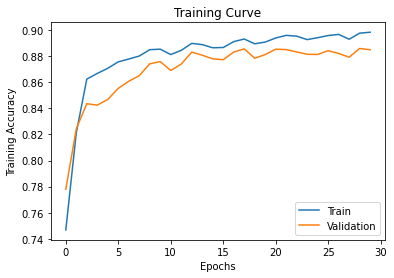

In [ ]:
# Main training loop for UNet
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 32,
    "epochs": 30,
    "seed": 0,
    "plot": True,
    "experiment_name": "segmentation_cnn",
    "visualize": False,
}
args.update(args_dict)
cnn = train(args)

### 4.2.1 Testing

In [ ]:
final_args = AttrDict()
final_args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 32,
    "epochs": 30,
    "seed": 0,
    "plot": True,
    "experiment_name": "segmentation_cnn",
    "visualize": False,
}
final_args.update(final_args_dict)

selected_model = UNet(final_args.kernel, final_args.num_filters)

if final_args.gpu and torch.cuda.is_available():
    selected_model = selected_model.cuda()

selected_model_path = get_model_name(final_args, epoch=18)
state = torch.load(os.path.join(os.getcwd()+"\\outputs", selected_model_path))
selected_model.load_state_dict(state)

<All keys matched successfully>

In [ ]:
train_loader, val_loader, test_loader = get_dataloader(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=args.batch_size)

test_acc = get_accuracy(selected_model, test_loader, final_args.gpu)
print('Test Accuracy:', test_acc)

Test Accuracy: 0.8948944160997733


### 4.2.3 Example

In [ ]:
# Example Visualization

# change directory here
##################################################################################################################################
demo_image = Image.open(os.path.join(os.getcwd()+"\\segmentation_dataset\\Images", 'raw lamb_0000073_1.jpg')) #input image
demo_label = Image.open(os.path.join(os.getcwd()+"\\segmentation_dataset\\Labels", 'raw lamb_0000073_1.jpg')) #label
##################################################################################################################################

# define a transform to convert a tensor to PIL image
tensor2image = transforms.ToPILImage()

(image_new, label_new), xx = image_processing (demo_image, demo_label) #image preprossing

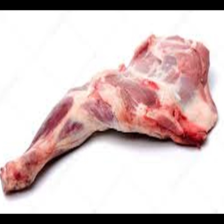

In [ ]:
image_new #input image

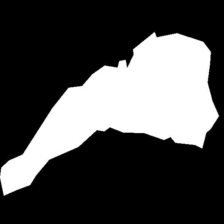

In [ ]:
label_new #label

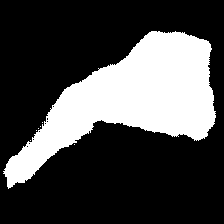

In [ ]:
# UNet output
tensor_img = img2tensor(image_new).view(-1,3,224,224).cuda()
out = selected_model(tensor_img)
pred = out.masked_fill_(out>=0.5, 1)
pred = pred.masked_fill_(pred<0.5, 0)
pred = pred.detach().cpu()[0]
mask = tensor2image(pred)
mask 

As shown in the sample prediction image below, we achieved good segmentation results on the meat but performed poorly on coins with UNet model. The problem is more severe when testing on new photos captured by ourselves. See Section 7.2. The volume estimation algorithm was also optimized to deal with this issue; see Part 8.

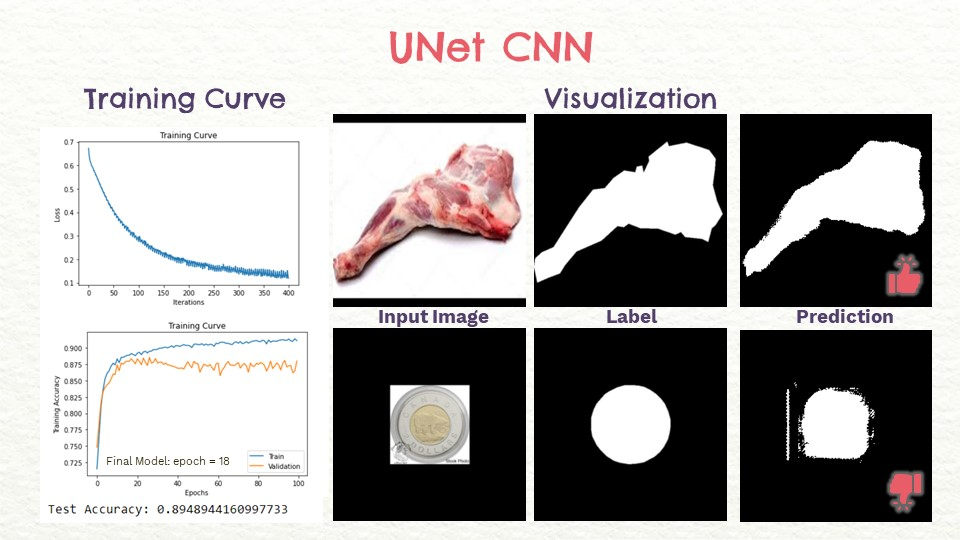

# Part 5. Volume Estimation

Since the shape of raw meat is usually irregular, the volume is approximated using cross-sectional area of topview image and thickness of the meat based on the assumption that the thickness of the meat slice is uniform.  

A toonie coin is used as reference in images taken by the user for area and thickness estimation. Since we know the actual dimension of  a toonie, the cross sectional area of meat is estimated by comparing the number of pixels in the output binary mask of meat and coin from UNet CNN. The thickness of the meat is estimated by comparing the height of output bounding boxes for meat and coin from YOLO.

**Algorithm**

In [ ]:
def image_processing_single (img, custom_padding=None, RESIZE=True):
    """
    input: 
          img: single image to be processed into UNet input format
          custom_padding: sequence, the cutom padding in torchvision.transforms.Pad format
          
    output: 
          image_new: image padded (and resized to 224*244 RGB if RESIZE)
          size: size after padding but before resizing, for maintaining proportion of different cropped images
    """
    if custom_padding != None:
        padding = custom_padding
    else:
        padding = get_padding(img)
    
    # Define transforms to convert the image to tensor
    pad_tf = transforms.Pad(padding=padding, fill=0, padding_mode='constant')
    resize_tf =  transforms.Resize((224,224))
    
    # process the image 
    image_new = pad_tf(img)
    
    size = image_new.size #size after padding
    
    if RESIZE:
        image_new = resize_tf(image_new)
    
    return image_new, size

def adjust_image_pair (meat_img, coin_img):
    """
    input: meat and coin images cropped using yolo bounding box
    output: meat and coin images padded with proportion preserved, resized to 224*244 RGB
    """
    
    meat_img_new, padded_size = image_processing_single (meat_img)
    coin_img_new, _ = image_processing_single (coin_img, custom_padding=get_padding(coin_img, custom_size=padded_size))

    return meat_img_new, coin_img_new, padded_size

def get_meat_height (meat_bbh, coin_bbh, alpha):
    """
    input: 
        meat_bbh, coin_bbh: meat and coin bounding box height from yolo
        alpha: a custom compensating factor 
    output: estimation of actual height of meat 
    """
    
    ACTUAL_TOONIE_DIA = 28 #mm    
    actual_meat_height = meat_bbh/coin_bbh*ACTUAL_TOONIE_DIA
    
    return actual_meat_height*alpha

def get_meat_area (meat_tensor, coin_tensor, orig_coin_area):
    """
    input: 
        meat_tensor, coin_tensor: meat and coin tensor output from cnn, size = 1*224*224
        orig_coin_area: the area of the unsegmented coin image in square pixel
    output: estimation of actual area of meat, UNet output masks for meat and coin 
    """
    
    ACTUAL_TOONIE_AREA = np.pi*14**2 #mm^2
    
    mask_meat = meat_tensor.masked_fill_(meat_tensor>=0.5, 1)
    mask_meat = mask_meat.masked_fill_(mask_meat<0.5, 0)
    mask_meat = mask_meat.detach().cpu()[0]
    
    mask_coin = coin_tensor.masked_fill_(coin_tensor>=0.5, 1)
    mask_coin = mask_coin.masked_fill_(mask_coin<0.5, 0)
    mask_coin = mask_coin.detach().cpu()[0]

    area_meat = np.sum(mask_meat.numpy())
    area_coin = np.sum(mask_coin.numpy())
    
    # adjust for poor segmentation results on coin image
    RATIO = np.pi*(0.5**2)/1 # the area ratio of the inscribed circle and the square
    if area_coin/orig_coin_area < RATIO: 
        area_coin = orig_coin_area * RATIO
    
    actual_meat_area = area_meat/area_coin*ACTUAL_TOONIE_AREA
    
    return actual_meat_area, mask_coin, mask_meat

def volume_estimation (model, img_meat_top, img_coin_top, meat_bbh_side, coin_bbh_side):
    """
    input: 
        model = segmentation model
        img_meat_top, img_coin_top = meat and coin images cropped using yolo bounding box
        meat_bbh_side, coin_bbh_side = meat and coin bounding box height from yolo       
    output: 
        volume: estimation of actual volume of meat 
        mask_coin, mask_meat: UNet output masks for meat and coin images
        meat_img_new, coin_img_new: meat and coin images padded with proportion preserved, resized to 224*244 RGB
    """    
    meat_img_new, coin_img_new, padded_size = adjust_image_pair (img_meat_top, img_coin_top)
    orig_coin_area = img_coin_top.size[0]*img_coin_top.size[1]/(padded_size[0]*padded_size[1])*224*224
    
    tensor_m = img2tensor(meat_img_new).view(-1,3,224,224).cuda()
    tensor_c = img2tensor(coin_img_new).view(-1,3,224,224).cuda()
    
    meat_tensor = model(tensor_m)
    coin_tensor =  model(tensor_c)
    
    actual_meat_area, mask_coin, mask_meat = get_meat_area (meat_tensor, coin_tensor, orig_coin_area)
    actual_meat_height = get_meat_height (meat_bbh_side, coin_bbh_side, 0.8)
    
    volume = actual_meat_area * actual_meat_height #mm^3
    print('Area:%.3f mm^2' % actual_meat_area)
    print('Height: %.3f mm' % actual_meat_height)
    
    return volume, mask_coin, mask_meat, meat_img_new, coin_img_new

# Part 6. Calories Calculation

The calorie information of different food categories are stored in a excel file named 'calorie.xlsx'. The list of food in the image and quality of countable food is generated using the label text from YOLO output. The weight of meat is estimated using volumn estimation algorithm in part5 above. The output is a dataframe containing list of food categories, quantity/weight and calories.

In [ ]:
#load excel file containing calories information of different food
import pandas as pd
df=pd.read_excel('calorie.xlsx',sheet_name='Sheet1')
df2=pd.read_excel('calorie.xlsx',sheet_name='Sheet2')
labelsDictionary={'egg': '0', 'rice': '1', 'pasta': '2', 'raw beef': '3', 'raw chicken': '4', 'raw lamb': '5', 
                  'raw pork': '6', 'apple': '7', 'banana': '8', 'bellpepper': '9', 'cabbage': '10', 
                  'carrot': '11', 'cauliflower': '12', 'chilli': '13', 'corn': '14', 'cucumber': '15', 
                  'eggplant': '16', 'garlic': '27', 'ginger': '28', 'grapes': '29', 'jalepeno': '30', 
                  'kiwi': '31', 'lemon': '32', 'lettuce': '33', 'mango': '34', 'onion': '35', 
                  'orange': '36', 'pear': '37', 'peas': '38', 'pineapple': '39', 'pomegranate': '40', 
                  'potato': '41', 'raddish': '42', 'spinach': '43', 'sweetpotato': '44', 
                  'tomato': '45', 'watermelon': '46', 'WhiteMushroom': '47', 'toonie': '48'}
inv_map = {v: k for k, v in labelsDictionary.items()}
veg_cal=df.replace(labelsDictionary)
meat_cal=df2.replace(labelsDictionary)[['category','calorie','density']]

In [ ]:
#function for calculating calories for each food category and output dataframe containing  food quantity and calories
def get_calorie(labels,volume):
  '''
  Input:
      Output label files from YOLO, example: xxxxx_0000x.txt
      Output meat volume estimation from UNet in part5 above, in mm^3
  Output:
      dataframe containing food categories,quantity and calories
  '''


  cal_list=[]
  cat_list=[]

  with open(labels, 'r') as f:
      for i in f.readlines():
          lab=i.split(' ')[0]
          #print (lab)
          if lab not in ['3','4','5','6','48']:
              cal=veg_cal[veg_cal.category==lab].values[0][1]
              cat=inv_map[str(lab)]
              cal_list.append(cal)
              cat_list.append(cat)
          if lab in ['3','4','5','6']:
            cal=round(meat_cal[meat_cal.category==lab].values[0][1]*volume,2)
            cat=inv_map[str(lab)]
            weight=meat_cal[meat_cal.category==lab].values[0][2]*0.94*volume/1000
            #print (weight)
            cal_list.append(cal)
            cat_list.append(cat) 
  cal=pd.DataFrame({'category':cat_list,'calorie':cal_list})
  cal=cal.groupby('category').agg(['count','sum']).rename(columns={"count": "quantity/weight(grams)", "sum": "calorie(cal)"})
  cal.columns =cal.columns.droplevel(0)

  for index, row in cal.iterrows(): 
      if 'raw' in index:
        cal.loc[index, 'quantity/weight(grams)'] = str(round(weight,2))+' g'
  cal.loc['Total'] = pd.Series(round(cal['calorie(cal)'].sum(),2), index = ['calorie(cal)'])
  return cal      

# Part 7. Integration


## 7.1 Full pipeline of use 

In [ ]:
# need to run all functions definitions in above sections first

########################## INPUT ################################
# pictures from web crawler or taken by phones
input_img_top = ?
input_img_side = ?

########################### YOLO ################################
# model included in YOLOv5m.rar
# run detect.py in Pycharm
# put the prediction result of YOLO:labelxxx.txt and the original pictures in the same folder, 
# the path from content root of the folder is saved in variable 'path'
# Using function defined in Part 3.4 to crop images and save in list

img_meat_top, img_coin_top, meat_bbh_side, coin_bbh_side = cropImg(path)


########################### UNet #################################
# load model
final_args = AttrDict()
final_args_dict = {
    "gpu": True,        # change to False if cuda not available
    "valid": False,
    "checkpoint": "",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 32,
    "epochs": 30,
    "seed": 0,
    "plot": True,
    "experiment_name": "segmentation_cnn",
    "visualize": False,
}
final_args.update(final_args_dict)

unet = UNet(final_args.kernel, final_args.num_filters)

if final_args.gpu and torch.cuda.is_available():
    unet = unet.cuda()
unet_path = unet(final_args, epoch=18)
state = torch.load(unet_path) # the provided state is on cuda
unet.load_state_dict(state)

###################### Volume Estimation #########################

top_m = img_meat_top #RGB image, cropped top image from yolo output, meat 
top_c = img_coin_top #RGB image, cropped top image from yolo output, toonie

bbh_m = meat_bbh_side #float, bounding box height from yolo output, meat
bbh_c = coin_bbh_side #float, bounding box height from yolo output, toonie

volume_est, _, _, _, _ = volume_estimation (unet, top_m, top_c, bbh_m, bbh_c)
print('Estimated volume: %.3f cm^3' % (volume_est/1000))

###################### Calories Calculation ######################
yolo_label = ? #labelxxx.txt in the same folder
get_calorie(yolo_label, volume = volume_est)

########################### THE END ###############################

## 7.2 Results on New Data

**Input Images:**
![](https://drive.google.com/uc?export=view&id=1AIqzZVYjOUPBHMeMNu1gLUnXC76JHTSr)

![](https://drive.google.com/uc?export=view&id=17ZtEF_Ev4yXn3Fnb7n-2ptZ6Z_9tGsI2)


**YOLO Outputs**: 

![](https://drive.google.com/uc?export=view&id=1pkTj11MCU8Pm004pNG7R9jED2uArdmuJ)  

![](https://drive.google.com/uc?export=view&id=1YrhSEVoGAJ1WJgKvgFGBQy6QSQ7NyitJ)  


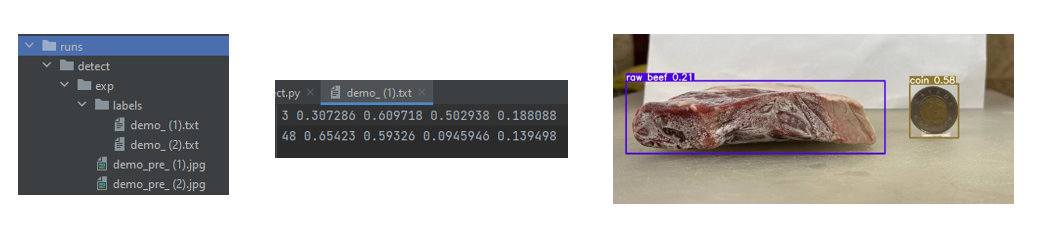

In [ ]:
###########################################################################
demo_m = Image.open('beef.jpg') #cropped top image from yolo output
demo_c = Image.open('coin.jpg')

side_m = Image.open('side_meat.jpg') #cropped side image from yolo output
side_c = Image.open('side_coin.jpg')
############################################################################

volume, mask_coin, mask_meat, meat_img_new, coin_img_new = volume_estimation (selected_model, demo_m, demo_c, side_m.size[1], side_c.size[1])
print('Estimated volume: %.3f cm^3' % (volume/1000))

Area:12862.274 mm^2
Height: 30.031 mm
Estimated volume: 386.264 cm^3


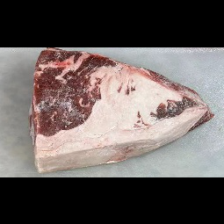

In [ ]:
meat_img_new

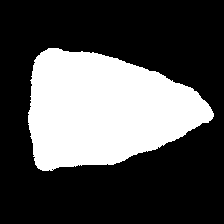

In [ ]:
mask_meat = tensor2image(mask_meat)
mask_meat

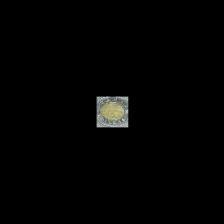

In [ ]:
coin_img_new #you can see the processed toonie image is very small

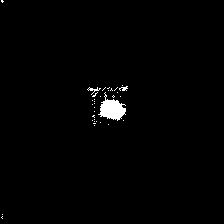

In [ ]:
mask_coin = tensor2image(mask_coin)
mask_coin # the result was not satisfactory, so the volume estimation was calculated otherwise. Details please see Part 5, get_meat_area function

In [ ]:
get_calorie('demo.txt',volume=386264)

quantity/weight(grams)  calorie(cal)
category                                     
apple                         1          95.0
banana                        2         210.0
egg                           1          63.0
raw beef               365.27 g         520.7
Total                       NaN         888.7

In [ ]:
# actual weight of beef: 217g
# calculated weight:     365g (67% larger)

# Part 8. Related Work

A similar project involving food calorie estimation using deep learning
https://arxiv.org/pdf/1706.04062.pdf

In this project, Faster R-CNN is implemeted for object detection(food and reference coin) The contour of each food is achieved with Gradcut while each food's colume is estimated by volume estimation formulas. The model achieved a mAP of 93% on the testing set.

#Part 9. Discusssion 


##9.1 YOLO



###9.1.1 Results

The YOLO model was trained for 300 epochs. The resulting overall mAP for an IoU threshold of 0.5 is around 65%.
The model performance varies across different classes. For example, the model performed well at recognizing apples, spinach, and reference coins; while it did poorly on pork and somehow completely failed on pasta. 

In general, the model was fairly accurate on most categories when the picture was not so crowded.


### 9.1.2 Insights

* The training dataset used initially for YOLO training lacks representativeness since the online images obtained by the crawler are brightly colored and the scale of food is very different from the actual ones. Our solution is to include some photos taken ourselves with various background and lighting conditions in the training set to improve the generalization ability of the model.
* False labeling has a significant negative impact on  YOLO model performance. During model training, there was an instance where a coin was mislabeled as beef causing 15% drop in recall and 5-10% drop in mAP.



##9.2 UNet CNN

###9.2.1 Results

The pixel-wise test accuracy of final UNet model was 89%. With validation dataset, the model achieved excellent segmentation results on the meat but performed poorly on coins. The problem is more severe when testing on new photos captured by ourselves.


### 9.2.2 Insights
*	The training dataset used for UNet CNN is imbalanced: only 20% of the images in the traning set are coin images with the rest being meat images. This resulted in undesirable image segmentation results on coin images.
* During the data preprocessing stage of training, the coin images are padded and resized to maintain the actual proportion of meat and coin before feeding into Unet. This resulted in most of the pixels in the coin training image being paddings and coin making up only a very small portion of the image. The output mask from the current UNet model doesn't clearly outline the coin and the resulting area of coin is much smaller than the actual area. Our current strategy is to use the dimension of cropped coin image multiplied by a factor instead of the segmentation results for toonie area to improve accuracy.
* There are three potential solutions: first, train with more coin images to improve the generalization capability of the model. Second, feed the model with resized coin image without paddings so that the coin image is more detailed which should result in more accurate binary masks. With this method, the proportion adjustment of coin images can be done after segmentation. And lastly train separate models for each food category, and hopefully the individual models will perform better on corresponding food categories compared to one generic model.



##9.3 Weight Estimation

### 9.3.1 Results 
With the demo image, the masking image output from UNet CNN clearly outline the shape of meat and reference coin. However, the estimated weight of the from image segmentation is 67% larger than the actual weight. 

### 9.3.2 Insights

There are two potential sources of error in weight estimation:
  
•	First, to reduce the overall complexity, the volume estimation algorithm is developed based on the assumption that meat thickness is uniform. However, the shape of raw meat is usually irregular and the bounding box hight associates with the thickness of meat at the thickest portion, thus using the thickness calculated from bounding box height will yield a larger volume.  

•	Secondly, the density of meat depends on temperature(frozen/unfrozen), and fat percentage. The density value we used here may be inaccurate considering the particular piece of steak used for demo is frozen and has high fat content.


In [5]:
%%shell
jupyter nbconvert --to html Image_based_Calorie_Calculator_walkthrough.ipynb

[NbConvertApp] Converting notebook Image_based_Calorie_Calculator_walkthrough.ipynb to html
[NbConvertApp] Writing 8721314 bytes to Image_based_Calorie_Calculator_walkthrough.html
